In [3]:
%matplotlib notebook
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
c = ['#43799d', '#cc5b46', '#ffbb00', '#71bc78']

# Q-Learner (meta learner)

In [2]:
class SimpleBandit(object):
    def __init__(self, prob, name=None):
        self.prob = prob
        self.name=name
        
    def sample(self):
        return np.random.choice(a=[0,1], p=[1-self.prob, self.prob])


class Learner(object):
    def __init__(self, alpha, beta, eta, psi, bandits, Q=None, TDE=None, last=None, history=None):
        if Q: 
            assert len(Q) == len(bandits)
        self.bandits = bandits
        self.Q = Q if Q else [0 for b in bandits]
        self.TDE = TDE if TDE else [0 for b in bandits]
        self.last = last if last else [0 for b in bandits]
        self.history = history if history else []
        self.alpha = alpha
        self.beta = beta
        self.eta = eta
        self.psi = psi
        self.counter = 1
        self.zeros_ = [0 for b in bandits]
        
    def get_probs(self):
        Q = np.array(self.Q)
        tderr = np.array(self.TDE)
        last = np.array(self.last)
        numer = np.exp(Q*self.beta + tderr*self.eta + last*self.psi)
        denom = np.sum(numer)
        return numer / denom

    def choose(self):
        self.counter += 1
        if all([self.Q[0]==q for q in self.Q]):
            c = random.choice(bandits)
            cid = bandits.index(c)
        else:
            c = np.random.choice(bandits, p=self.get_probs())
            cid = bandits.index(c)
        r = c.sample()
        delta = r-self.Q[cid]
        self.Q[cid] = self.Q[cid] + self.alpha*delta
        self.TDE[cid] = (self.TDE[cid] + delta)/self.counter
        last = self.zeros_
        last[cid] = 1
        self.last = last
        self.history.append(self.Q + [c.name, r, delta])
    
    def hist_df(self):
        return pd.DataFrame(self.history, columns=(['Q({})'.format(b.name) for b in bandits]+['c','r','delta']))

            

In [7]:
random.seed(2)
np.random.seed(4)

b50, b60 = SimpleBandit(.50, 'b50'), SimpleBandit(.60, 'b60')
b75, b85 = SimpleBandit(.80, 'b75'), SimpleBandit(.90, 'b90')
bandits = [b85, b75, b60, b50]

a = Learner(alpha=.2, beta=1, eta=-5, psi=4.4, bandits=bandits)
N = 200
for t in range(N):
    a.choose()

df = a.hist_df()    

for i, b, in enumerate(bandits):
    plt.plot(df['Q({})'.format(b.name)][df.c==b.name].rolling(5, min_periods=1).mean(), c=c[i], label='{} Q'.format(b.name))

    plt.plot(df['delta'][df.c==b.name].rolling(N, min_periods=1).mean(), c=c[i], ls=':', label='{} delta'.format(b.name))

    trials = np.nonzero([df.c==b.name])[1]
    plt.scatter(trials, np.ones_like(trials)+.05, marker='|', c=c[i], s=8, label='{} choice'.format(b.name))


plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()

NameError: name 'SimpleBandit' is not defined

In [30]:
pmaj = np.arange(.6,.91,.05)

N = 500

df = []
for consensus in pmaj:
    for i in range(N):
        representations = np.array([np.random.choice(a=[0,1], p=[1-consensus, consensus]) for j in range(7)])
        if np.all(representations[0] == representations[1:3]): representations = representations[:3]
        p_hat = np.mean(representations)
        q_hat = 1 - p_hat
        sc = 1 - np.sqrt(p_hat * q_hat)
        
        counts = np.bincount(representations)
        response = np.argmax(counts)
    
        df.append([i, consensus, response, sc])

df = pd.DataFrame(np.stack(df), columns = 'sid,pmaj,response,sc'.split(','))

data = df.groupby(['pmaj','response']).agg({'sc': 'mean'}).reset_index()
data = df.groupby(['pmaj']).agg({'response': 'mean'}).reset_index()
print(data)

# major = data.loc[data.response==1, 'sc']
# minor = data.loc[data.response==0, 'sc']

# plt.figure('SCM')

# plt.plot(pmaj, major)
# plt.plot(pmaj, minor)

   pmaj  response
0  0.60     0.690
1  0.65     0.800
2  0.70     0.858
3  0.75     0.924
4  0.80     0.962
5  0.85     0.980
6  0.90     0.996


# Bayesian concept learner

In [6]:
class MonsterI1D(object):
    def __init__(self, d1, d2):
        self.d1 = d1
        self.d2 = d2
        self.rule = 0 if d1 <= 3 else 1
        self.food = 'AB'[self.rule]
    
    def describe(self):
        print('d1 = {}, d2 = {}, food {}'.format(self.d1, self.d2, self.food))

def make_random_monsterI1D():
    return MonsterI1D(np.random.randint(1,7), np.random.randint(1,7))



d1 = 5, d2 = 1, food B
d1 = 4, d2 = 6, food B
d1 = 4, d2 = 3, food B
d1 = 3, d2 = 4, food A
d1 = 4, d2 = 3, food B
d1 = 1, d2 = 4, food A
d1 = 6, d2 = 6, food B
d1 = 4, d2 = 6, food B
d1 = 1, d2 = 2, food A
d1 = 3, d2 = 4, food A


<IPython.core.display.Javascript object>


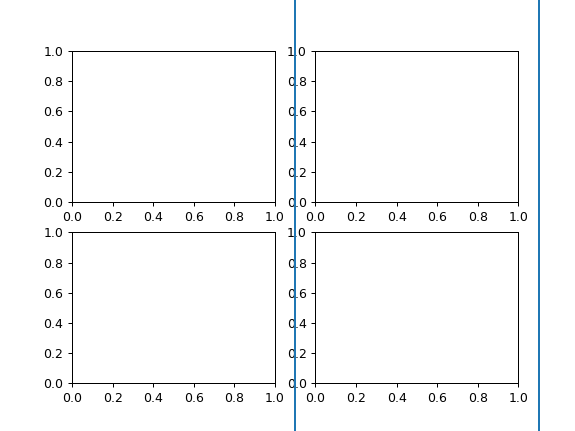

In [32]:
import matplotlib as mpl

newf = plt.figure('newf')
for i in range(4):
    ax = newf.add_subplot(221+i)
    trans = mpl.transforms.blended_transform_factory(ax.transAxes, newf.transFigure)

    newf.lines.append(mpl.lines.Line2D([1.1,1.1],[0,1], transform=trans))
# newf.canvas.draw_idle()